<a href="https://colab.research.google.com/github/JMC110/Ungraded-Assignment-5/blob/master/TF_AutoMPG_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

2.2.0-rc3


In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()


In [0]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

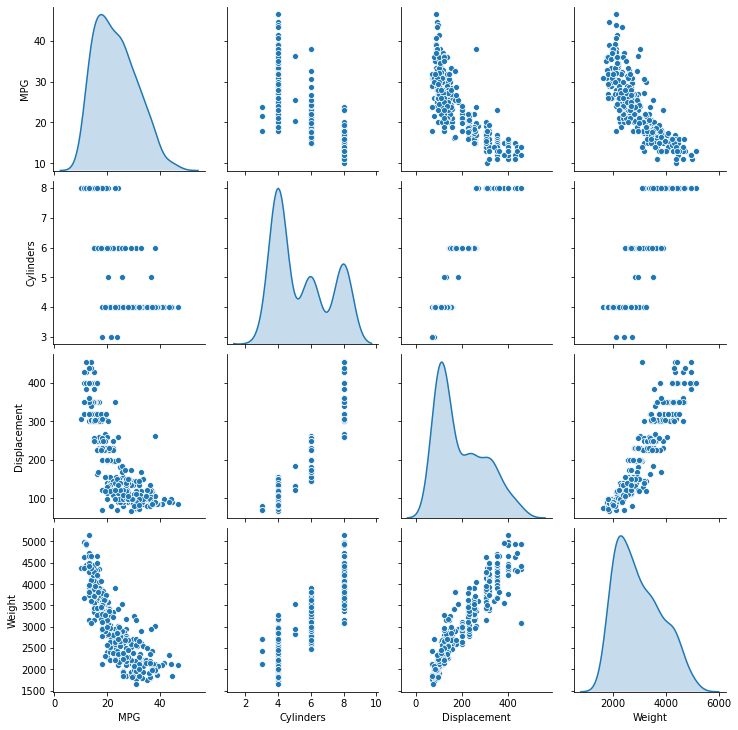

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normalization

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
print(normed_train_data)

     Cylinders  Displacement  Horsepower  ...    Europe     Japan       USA
146  -0.869348     -1.009459   -0.784052  ... -0.465148 -0.495225  0.774676
282  -0.869348     -0.530218   -0.442811  ... -0.465148 -0.495225  0.774676
69    1.483887      1.482595    1.447140  ... -0.465148 -0.495225  0.774676
378  -0.869348     -0.865687   -1.099044  ... -0.465148 -0.495225  0.774676
331  -0.869348     -0.942365   -0.994047  ... -0.465148  2.012852 -1.286751
..         ...           ...         ...  ...       ...       ...       ...
281   0.307270      0.044872   -0.521559  ... -0.465148 -0.495225  0.774676
229   1.483887      1.961837    1.972127  ... -0.465148 -0.495225  0.774676
150  -0.869348     -0.836932   -0.311564  ... -0.465148  2.012852 -1.286751
145  -0.869348     -1.076553   -1.151543  ... -0.465148  2.012852 -1.286751
182  -0.869348     -0.846517   -0.495310  ...  2.143005 -0.495225 -1.286751

[314 rows x 9 columns]


model Using Keras

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()


In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.23955637],
       [-0.28348297],
       [ 0.25984997],
       [-0.43108696],
       [-0.2473528 ],
       [ 0.03359783],
       [-0.2866545 ],
       [-0.6656987 ],
       [ 0.06954753],
       [-0.09261419]], dtype=float32)

In [20]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:568.7632,  mae:22.5663,  mse:571.1590,  val_loss:560.7068,  val_mae:22.2977,  val_mse:561.0439,  
....................................................................................................
Epoch: 100, loss:5.9868,  mae:1.6954,  mse:5.9792,  val_loss:8.0995,  val_mae:2.1529,  val_mse:8.0957,  
....................................................................................................
Epoch: 200, loss:5.2466,  mae:1.5810,  mse:5.2904,  val_loss:8.7192,  val_mae:2.2785,  val_mse:8.7055,  
....................................................................................................
Epoch: 300, loss:4.8698,  mae:1.4552,  mse:4.8563,  val_loss:8.8753,  val_mae:2.1971,  val_mse:8.8657,  
....................................................................................................
Epoch: 400, loss:4.5448,  mae:1.3958,  mse:4.5391,  val_loss:8.8171,  val_mae:2.2344,  val_mse:8.8008,  
..............................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.721161,1.044649,2.719284,9.590093,2.281981,9.573778,995
996,2.991635,1.148464,2.997294,8.618557,2.193743,8.592966,996
997,2.905055,1.129778,2.928196,8.563671,2.260562,8.526273,997
998,2.847433,1.060168,2.835126,8.626769,2.201027,8.596742,998
999,2.832304,1.082961,2.856337,9.055172,2.328920,9.008501,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

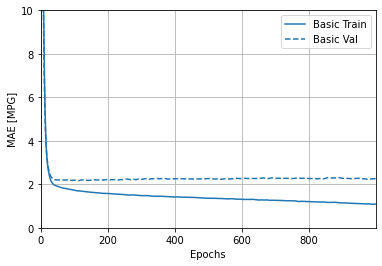

In [23]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

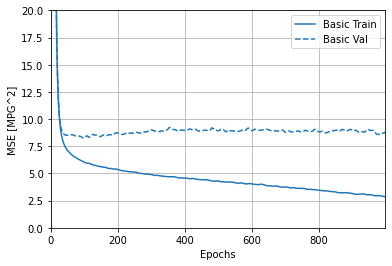

In [24]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

Early Stoppping

In [25]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:567.4965,  mae:22.5098,  mse:567.8185,  val_loss:559.8682,  val_mae:22.2569,  val_mse:560.2397,  
.............................................................

Text(0, 0.5, 'MAE [MPG]')

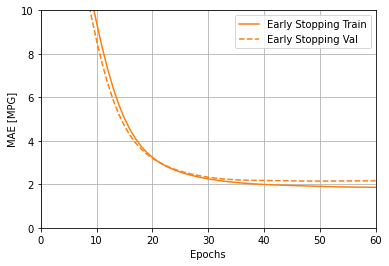

In [26]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.2326 - mae: 1.9014 - mse: 5.9486
Testing set Mean Abs Error:  1.90 MPG


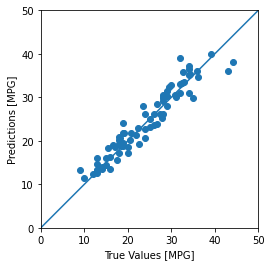

In [28]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


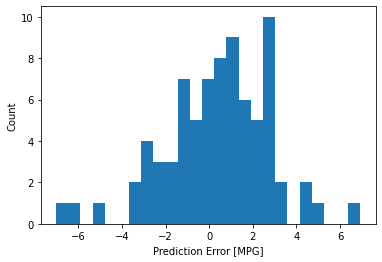

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")